# SchrodingerEq.jl

A project for the Computational Physics UW course (module III), by Laura Sberna.

We upload the necessary packages and set some parameters:

In [1]:
using LinearAlgebra
using Plots

In [2]:
m = 16.
hbar = 1.
t0 = 0.

0.0

## PLC Functions

I use the Piecewise Linear Continuous functions discussed in lecture (numer, link to github). 

In [3]:
struct PLCFun{T,U}
    points::Vector{U}
end

In [4]:
function Base. *(a::U, f::PLCFun{T,U})::PLCFun{T,U} where {T,U}
 PLCFun{T,U}(a .* f.points)
end

function Base. +(g::PLCFun{T,U}, f::PLCFun{T,U})::PLCFun{T,U} where {T,U}
    @assert length(f.points) == length(g.points) ## gives error message if not satisfied
 PLCFun{T,U}(g.points .+ f.points)
end

In [5]:
function xcoord(::Type{T}, nlines::Int, i::Int)::T where {T,U}
    dx = 1 / nlines
    @assert 1 <= i <= nlines+1
    x = (i-1) * dx
    x
end

xcoord (generic function with 1 method)

In [6]:
function lineindex(f::PLCFun{T,U}, x::T)::Int where {T,U}
    @assert 0 <= x <= 1
    nlines=length(f.points)-1
    dx = 1 / nlines
    i = floor(Int, x / dx) + 1
    i = max(1,i)
    i = min(nlines, i)
    i
end

lineindex (generic function with 1 method)

In [7]:
function samplePLC(::Type{T}, ::Type{U}, nlines::Int, f::Function)::PLCFun{T,U} where {T,U}
    ys = U[f(xcoord(T, nlines, i)) for i in 1:nlines+1]
    PLCFun{T,U}(ys)
end

samplePLC (generic function with 1 method)

In [8]:
function linterp(x1::T, y1::U, x2::T, y2::U, x::T)::U where {T,U}
    y1 * (x - x2) / (x1 - x2) + y2 * (x - x1) / (x2 - x1)
end

linterp (generic function with 1 method)

In [9]:
function evaluate(f::PLCFun{T,U}, x::T)::U where {T,U}
    @assert 0 <= x <= 1
    nlines=length(f.points)-1
    i = lineindex(f, x)
    x1=xcoord(T, nlines, i)
    x2=xcoord(T, nlines, i+1)
    y1=f.points[i]
    y2=f.points[i+1]
    y = linterp(x1, y1, x2, y2, x)
    y
end

evaluate (generic function with 1 method)

The second order central finite diferrence scheme for the second order derivative is obtained as follows. We write the Taylor expansions
\begin{align}
f(x_{j-1})&=f(x_j)-\Delta x f'(x_j) + \frac{\Delta x^2}{2} f''(x_j) + O(\Delta x ^3)\\ 
f(x_{j})&=f(x_j) \\
f(x_{j+1})&=f(x_j)+\Delta x f'(x_j) + \frac{\Delta x^2}{2} f''(x_j) + O(\Delta x ^3) \\ 
\end{align}
from which
\begin{equation}
f''(x_j) = \frac{f(x_{j+1}) -2f(x_{j}) + f(x_{j-1})}{\Delta x^2} + O(\Delta x ^3) 
\end{equation}
We also put the system in a box: at the endpoints, we use the left or right scheme and set $f(boundary)=0$:
\begin{align}
f''(x_j) &= \frac{ f(x_{j+2})-2 f(x_{j+1}) }{\Delta x^2} + O(\Delta x ^3)  \ \ \ (left \ boundary) \\
f''(x_j) &= \frac{f(x_{j-2})-2 f(x_{j-1}) }{\Delta x^2} + O(\Delta x ^3)  \ \ \ (right \  boundary)
\end{align}

In [10]:
function derivSecondCenter(f::PLCFun{T,U})::PLCFun{T,U} where {T,U} 
    nlines=length(f.points)-1
    dx = 1 / nlines
    ys=U[(f.points[3] - 2*f.points[2] + f.points[1]) /(dx^2) ;[(f.points[i+1] - 2*f.points[i] + f.points[i-1]) /(dx^2) for i in 2:nlines]; (f.points[end-2] - 2*f.points[end-1] + f.points[end]) /(dx^2)]
    PLCFun{T,U}(ys)
end

derivSecondCenter (generic function with 1 method)

In [11]:
fsin = samplePLC(Float64, Float64, 100, sinpi) # test
evaluate(fsin, 0.3333), sin(0.3333)

(0.8658783625071171, 0.32716319804950605)

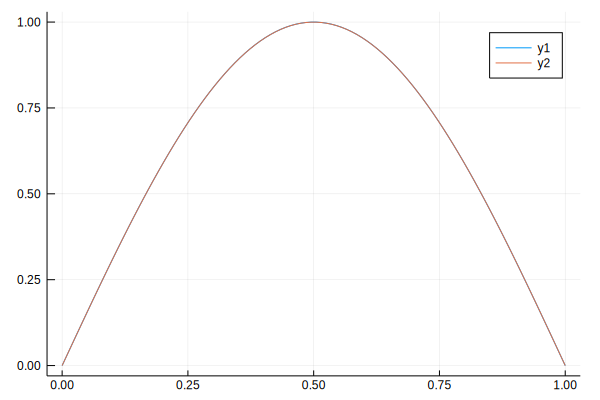

In [12]:
xs = collect(range(0, stop=1, length=100))
plot(xs, sinpi.(xs))
plot!(xs, [evaluate(fsin, x) for x in xs])

## The Schroedinger equation

Implicit methods for parabolic equations require very small time steps. For this reason it is better to implement higher order time integrators than Euler, like Runge-Kutta 2 or 4.

In [13]:
struct WaveFunction{T, U}
    time::T
    psi::PLCFun{T,U}
end

In [14]:
function Base. *(a::U, f::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
 WaveFunction{T, U}(f.time, a * f.psi)
end

function Base. *(v::PLCFun{T,Float64}, f::PLCFun{T,U})::PLCFun{T,U} where {T,U}
    @assert length(v.points)==length(f.points)
    PLCFun{T,U}(v.points .* f.points)
end

function Base. +(g::WaveFunction{T, U}, f::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
    @assert abs(f.time - g.time) <= 100*eps(T)
 WaveFunction{T, U}(f.time, g.psi + f.psi)
end

In [15]:
function gaussian(x::T, x0::T, sigmax::T, p::T)::Complex{Float64} where {T}
    1 / sqrt(sqrt(pi * sigmax^2)) * exp( - (x-x0)^2 / ( 2 * sigmax^2 ) + im * p * (x-x0))
end

gaussian (generic function with 1 method)

In [16]:
function initialGaussian(nlines::Int, x0::Float64, sigmax::Float64, p::Float64)::WaveFunction{Float64, Complex{Float64}}
    t = 0
    y = samplePLC(Float64, Complex{Float64}, nlines, x -> gaussian(x,x0,sigmax,p))
    WaveFunction{Float64, Complex{Float64}}(t,y)
end

initialGaussian (generic function with 1 method)

In [66]:
function potential(nlines::Int)::PLCFun{Float64,Float64}
    samplePLC(Float64, Float64, nlines,V)
end

potential (generic function with 1 method)

In [67]:
function rhsSchroedinger(s::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
    t = s.time
    psi = s.psi
    nlines = length(psi.points) - 1
    psixx = (- im / hbar) * ((- hbar^2 / ( 2*m) + im * 0.) * derivSecondCenter(psi) + potential(nlines) * psi)
    psit = PLCFun{T,U}(U[0;[psixx.points[i] for i in 2:nlines]; 0])
    WaveFunction{T, U}(t, psit)
end

rhsSchroedinger (generic function with 1 method)

In [68]:
function euler(rhs::Function, dt::T,
               s0::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
    r0 = rhs(s0)
    s1 = s0 + (dt + im * 0.)  * r0
    WaveFunction{T, U}(r0.time + dt, s1.psi)
end

euler (generic function with 1 method)

In [69]:
function RK2(rhs::Function, dt::T,
               s0::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
    r0 = rhs(s0)
    smiddle = s0 + (dt / 2 + im * 0.)  * r0
    rmiddle = rhs(smiddle)
    s1 = s0 + (dt + im * 0.)  * rmiddle
    WaveFunction{T, U}(r0.time + dt, s1.psi)
end

RK2 (generic function with 1 method)

In [70]:
function RK4(rhs::Function, dt::T,
               s0::WaveFunction{T, U})::WaveFunction{T, U} where {T,U}
    k1 = rhs(s0)
    k2 = rhs(s0 + (dt / 2 + im * 0.)  * k1)
    k3 = rhs(s0 + (dt / 2 + im * 0.)  * k2)
    k4 = rhs(s0 + (dt  + im * 0.)  * k3)
    s1 = s0 + (dt / 6 + im * 0.)  * (k1 + (2. + im * 0.) *k2 + (2. + im * 0.) *k3 + k4)
    WaveFunction{T, U}(s0.time + dt, s1.psi)
end

RK4 (generic function with 1 method)

In [71]:
struct solution{T,U}
    dt::T
    dx::T
    states::Vector{WaveFunction{T, U}}
end

In [72]:
function solveSchrodinger(tmax::T, nlines::Int, lambda::T, x0::T, sigmax::T, p::T) where {T}
    s=initialGaussian(nlines, x0, sigmax, p)
    dx= 1/nlines
    dt=lambda * dx
    nsteps= round(Int, tmax / dt)
    sol = solution{T,Complex{T}}(dt, dx, WaveFunction{T, Complex{T}}[])
    push!(sol.states, s)
    
    for step in 1:nsteps
        s = RK4(rhsSchroedinger, dt, s)
        push!(sol.states, s)
    end
    return sol
end

solveSchrodinger (generic function with 1 method)

In [73]:
function refine(u::PLCFun{T,U})::PLCFun{T,U} where {T,U}
    nlines = length(u.points) - 1
    dx = 1 / nlines
    eval = [evaluate(u, xcoord(T, 2 * nlines, i)) for i in 1:2*nlines+1]
    PLCFun{T,U}(eval)
end

refine (generic function with 1 method)

In [74]:
function totprob(u::PLCFun{T,U}, dx::T)::T where {T,U}
    dx*sum(abs.(u.points) .^2)
end

totprob (generic function with 1 method)

## Free particle in a box

In [26]:
function V(x::T)::Float64 where {T}
    0.
end

V (generic function with 1 method)

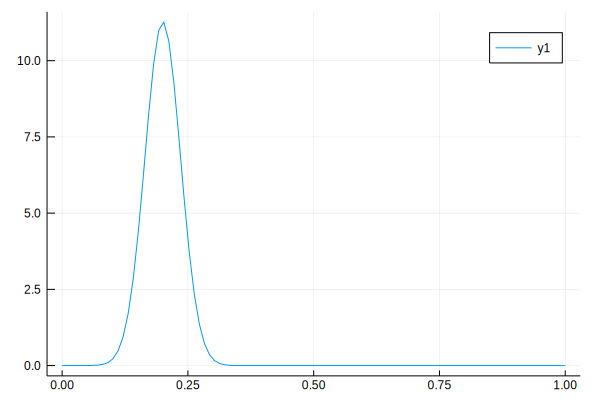

In [27]:
s0 = initialGaussian(500, 0.2, 0.05, 1.)
xs = collect(range(0, stop=1, length=100))
plot(xs, [abs(evaluate(s0.psi, x))^2 for x in xs] )

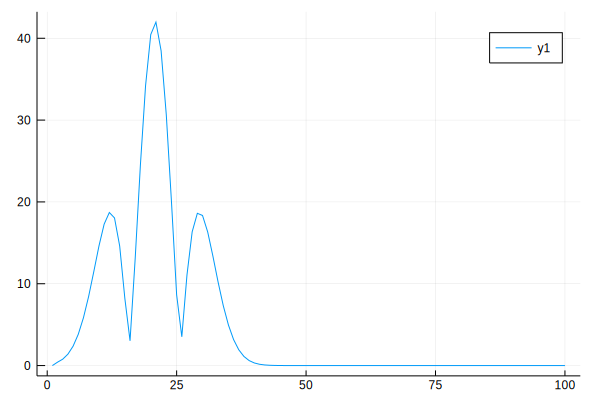

In [28]:
rhsSchroedinger(s0)
plot([abs(evaluate(rhsSchroedinger(s0).psi, x)) for x in xs])

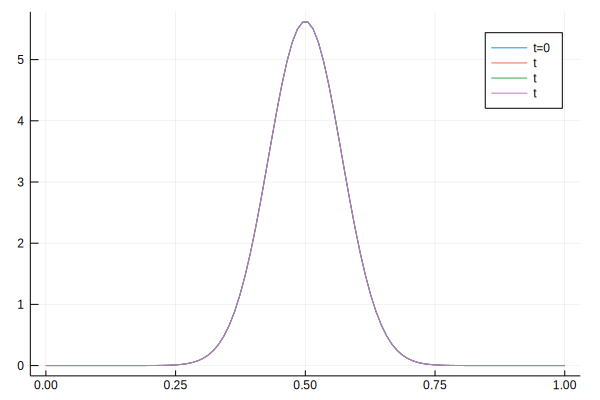

In [29]:
x0 = 0.5
sigmax = 0.1
p = 2.
n = 100
s0 = initialGaussian(n, x0, sigmax, p)
xs = collect(range(0, stop=1, length=n))
s1 = euler(rhsSchroedinger, 0.00001, s0)
s1rk2 = RK2(rhsSchroedinger, 0.00001, s0)
s1rk4 = RK4(rhsSchroedinger, 0.00001, s0)

plot( xs, [abs(evaluate(s0.psi, x))^2 for x in xs] , label= "t=0")
plot!(xs,  [abs(evaluate(s1.psi, x))^2 for x in xs] , label= "t")
plot!(xs,  [abs(evaluate(s1rk2.psi, x))^2 for x in xs] , label= "t")
plot!(xs,  [abs(evaluate(s1rk4.psi, x))^2 for x in xs] , label= "t")

In [30]:
#solveSchrodinger(tmax::T, nlines::Int, lambda::T, x0::T, sigmax::T, p::T)
x0 = 0.5
sigmax = 0.1
p = 2.
n = 100
T = 1.
lambda = 0.05  # 0.1 for RK4, 0.05 for RK2, 0.001 for Euler
xs = collect(range(0, stop=1, length=n))
sol = solveSchrodinger(T, n, lambda, x0, sigmax, p);

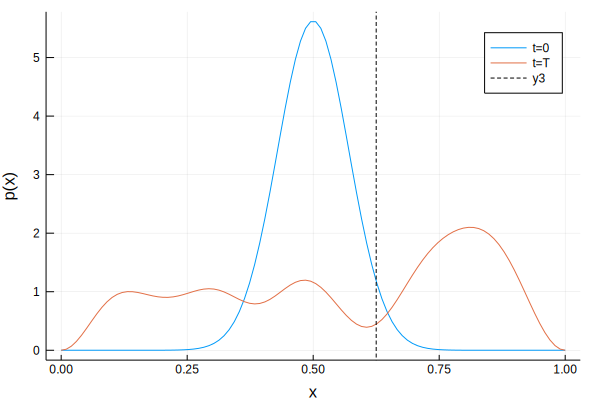

In [31]:
plot(xs, [abs(evaluate(sol.states[1].psi, x))^2 for x in xs], label = "t=0", xlabel = "x", ylabel = "p(x)")

#for i in 2:500:length(sol.states)
#    plot!(xs, [abs(evaluate(sol.states[i].psi, x))^2 for x in xs])
#end
#plot!()
plot!(xs, [abs(evaluate(sol.states[end].psi, x))^2 for x in xs], label = "t=T")
plot!([x0 + p / m * T * hbar], seriestype = :vline, linestyle = :dash, linecolor= :black)

An animation of the solution. The dashed line indicates the classical evolution of a particle starting at $x_0$ with momentum $p \hbar$

In [32]:
@gif for i=1:length(sol.states)
    plot(xs, [abs(evaluate(sol.states[i].psi, x))^2 for x in xs], xlabel = "x", ylabel = "p(x)", legend = :false, 
    xlim = (0,1), ylim = (0,4.2))
    plot!([x0 + p / m * (lambda / n * i) * hbar], seriestype = :vline, linestyle = :dash, 
        linecolor= :black, linealpha= 0.8)
end every 10

InterruptException: InterruptException:

### Convergence tests
We first check that the total probability is conserved (that the evolution is unitary). Explicit methods are not expected to conserve probability, in general, since they approximate the evolution operator with a non-unitary operator.

In [52]:
x0 = 0.2
sigmax = 0.05
p = 32.
n = 500
T = 0.25
lambda = 0.01  
xs = collect(range(0, stop=1, length=n))
sol1 = solveSchrodinger(T, n, lambda, x0, sigmax, p);
#sol2 = solveSchrodinger(T, n, lambda/2, x0, sigmax, p);
#sol4 = solveSchrodinger(T, n*100, lambda, x0, sigmax, p);

In [53]:
ts = [i for i in 0:(lambda / n):T]
#psianalytic=zeros(length(ts),length(xs))
#for t in ts
#    for x in xs
psianalyticsol(x,t) = 1 /pi^(1/4) / sqrt(sigmax + im*hbar*t /(m*sigmax)) * exp(- im * t*p^2 / (2*m) + im * p * (x-x0) - (x -x0 - hbar*p*t/m)^2/(2*(sigmax^2 + im*hbar*t / m)) )

psianalyticsol (generic function with 1 method)

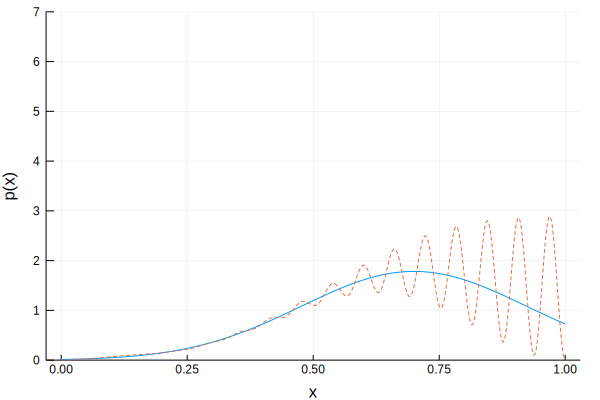

In [54]:
plot(xs,[abs(psianalyticsol(x,T))^2 for x in xs], ylim=(0,7))
plot!(xs, [abs(evaluate(sol1.states[end].psi, x))^2 for x in xs], 
    xlabel = "x", ylabel = "p(x)", legend = :false, linestyle = :dash)

In [55]:
@gif for i=1:length(sol1.states)
    plot(xs, [abs(evaluate(sol1.states[i].psi, x))^2 for x in xs], xlabel = "x", ylabel = "p(x)", legend = :false, 
    xlim = (0,1), ylim = (0,7))
    plot!([x0 + p / m * (lambda / n * i) * hbar], seriestype = :vline, linestyle = :dash, 
        linecolor= :black, linealpha= 0.8)
    plot!(xs,[abs(psianalyticsol(x,i*lambda/n))^2 for x in xs], linestyle= :dash)
    end every 250

┌ Info: Saved animation to 
│   fn = /Users/laurasberna/JuliaProjects/DifferentialEquationsModule.jl/SchrodingerEq.jl/tmp.gif
└ @ Plots /Users/laurasberna/.julia/packages/Plots/rmogG/src/animation.jl:90


Plots.AnimatedGif("/Users/laurasberna/JuliaProjects/DifferentialEquationsModule.jl/SchrodingerEq.jl/tmp.gif")

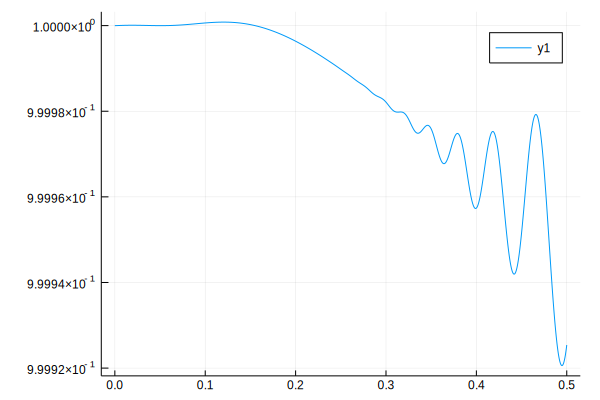

In [37]:
plot([i for i in 0:(lambda / n):T] , [totprob(sol1.states[i].psi, sol1.dx) for i in 1:length(sol1.states)])
#plot!([i for i in 0:(lambda/2 / n):T] , [totprob(sol2.states[i].psi, sol4.dx) for i in 1:length(sol2.states)])
#plot!([i for i in 0:(lambda/100 / n):T] , [totprob(sol4.states[i].psi, sol4.dx) for i in 1:length(sol4.states)],
#ylim = (0.9995,1.0005))

Convergence test:

In [38]:
x0 = 0.5
sigmax = 0.1
p = 2.
n = 100
T = .5
lambda = 0.05  # 0.1 for RK4, 0.05 for RK2, 0.001 for Euler
xs = collect(range(0, stop=1, length=n))
sol1 = solveSchrodinger(T, n, lambda, x0, sigmax, p);
sol2 = solveSchrodinger(T, 2*n, lambda, x0, sigmax, p);
sol4 = solveSchrodinger(T, 4*n, lambda, x0, sigmax, p);

InterruptException: InterruptException:

In [39]:
ue1=refine(refine(sol1.states[end].psi)) + (-1.0 + im * 0.) * refine(sol2.states[end].psi) ;
ue2=refine(sol2.states[end].psi) + (-1.0 + im * 0.) * sol4.states[end].psi ;
xs = collect(range(0, stop=1, length=4*n))
plot([abs(evaluate(ue1, x) ./ evaluate(ue2, x)) for x in xs])

UndefVarError: UndefVarError: sol4 not defined

## Barrier in a box

In [62]:
function V(x::T)::Float64 where {T}
    if x<0.4 && x>0.5 return 0. 
        else return 50.
    end
end

V (generic function with 1 method)

In [75]:
x0 = 0.2
sigmax = 0.05
p = 32.
n = 500
T = 0.25
lambda = 0.01  
xs = collect(range(0, stop=1, length=n))
sol1 = solveSchrodinger(T, n, lambda, x0, sigmax, p);

In [61]:
p^2/(2*m)

32.0

In [76]:
ts = [i for i in 0:(lambda / n):T]
psianalyticsol(x,t) = 1 /pi^(1/4) / sqrt(sigmax + im*hbar*t /(m*sigmax)) * exp(- im * t*p^2 / (2*m) + im * p * (x-x0) - (x -x0 - hbar*p*t/m)^2/(2*(sigmax^2 + im*hbar*t / m)) )

psianalyticsol (generic function with 1 method)

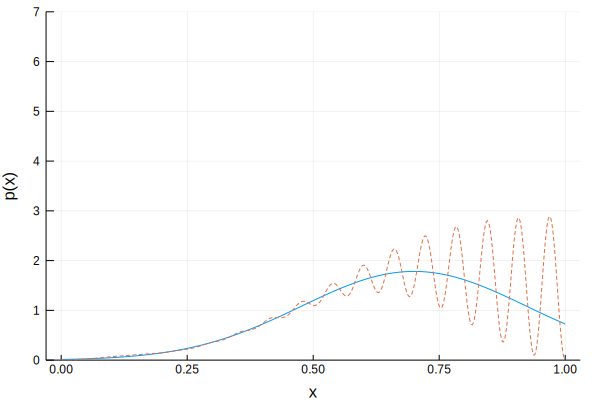

In [77]:
plot(xs,[abs(psianalyticsol(x,T))^2 for x in xs], ylim=(0,7))
plot!(xs, [abs(evaluate(sol1.states[end].psi, x))^2 for x in xs], 
    xlabel = "x", ylabel = "p(x)", legend = :false, linestyle = :dash)

In [78]:
@gif for i=1:length(sol1.states)
    plot(xs, [abs(evaluate(sol1.states[i].psi, x))^2 for x in xs], xlabel = "x", ylabel = "p(x)", legend = :false, 
    xlim = (0,1), ylim = (0,7))
    plot!([x0 + p / m * (lambda / n * i) * hbar], seriestype = :vline, linestyle = :dash, 
        linecolor= :black, linealpha= 0.8)
    plot!(xs,[abs(psianalyticsol(x,i*lambda/n))^2 for x in xs], linestyle= :dash)
    end every 250

┌ Info: Saved animation to 
│   fn = /Users/laurasberna/JuliaProjects/DifferentialEquationsModule.jl/SchrodingerEq.jl/tmp.gif
└ @ Plots /Users/laurasberna/.julia/packages/Plots/rmogG/src/animation.jl:90


Plots.AnimatedGif("/Users/laurasberna/JuliaProjects/DifferentialEquationsModule.jl/SchrodingerEq.jl/tmp.gif")

### Convergence tests

## Comparison with Suzuki-Trotter solver